In [ ]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

# Lecture 8. PDEs and sparse matrices

## Previous lecture
- Properties of the H-matrices
- Block matrix inversion
- Nullity theorem

## Todays lecture
- Where the sparse matrices come from
- A brief reminder: how to store a sparse matrix
- How to multiply it by vector
- How to solver linear systems with sparse matrices fast.

## PDEs

Partial differential equations (PDEs) are ubiquitous in mathematical modelling

From simple linear PDEs to more compicated nonlinear cases:

diffusion, heat conducation, fluid dynamics, reaction-diffusion, etc.

## Sparse matrices

After any convenient **local discretization**,  i.e.

- Galerkin method with local basis function (finite element method, FEM)
- Finite difference method
- Finite volume method 

We get matrices with **a lot of zeros**, typically called **sparse matrices**.

## Sparse vs Dense matrices

- [Wilkinson] a sparse matrix is a matrix with enough zeros that is worth taking advantage of them
- A **structured matrix** has enough structure that is worthwhile using it (i.e., Toeplitz + FFT)
- A dense matrix is neither sparse nor structured.

## Design of sparse matrix data structure

- Most operations should give the same result for dense and sparse
- Storage should be $\mathcal{O}(\mathrm{nonzeros})$.
- Time for a sparse matrix operations should be $\mathcal{O}(\mathrm{nflops})$ 

The last requirement basically means fewer cache misses.

## Storing a sparse matrix

That we already discussed in detail in a separate lecture in the NLA course. However, let us repeat a little bit.

- Coordinate storage, $(i, j)$ array. 
- Compressed sparse row formata, $(ia, ja, sa)$ format.
- There is also compressed row storage

What is good for what?

## Matrix-by-vector product

The matrix-by-vector product is very easy to be implemented in the compressed sparse row format:

``
for i in range(n):
       for k in range(ia[i]:ia[i+1]):
           y[i] += sa[k] * x[ja[k]]
``

## Summary of CSR

- CSR is good for matrix-by-vector product
- Insertion  of new elements is very expensive.

## Efficiency of sparse matrix operations

Sparse matrix operations are mostly about **memory access**, not about operations, thus the efficiency in flops is typically very low;

thus, efficiency of order 10-15\% is considered **high**.

Let us test it.

In [41]:
import numpy as np
import time
n = 4000
a = np.random.randn(n, n)
v = np.random.randn(n)
t = time.time()
np.dot(a, v)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  ((2 * n ** 2)/t) / 10 ** 9))


Time:  1.5e-02, Efficiency:  2.1e+00 Gflops


In [51]:
import scipy as sp
import scipy.sparse
n = 4000
r = 100
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n, r)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n * r) / t / 10 ** 9))


Time:  2.6e-03, Efficiency:  4.7e-01 Gflops


## Morale
The computational time is smaller, the computatational efficiency is also smaller.

## Possible solutions

- Use blocking
- Use block matrix-by-vector product (multiply at once)

## What are FastPDE methods about

- They are typically methods for large sparse linear systemse 
- These systems have **certain additional structure**, i.e. it is not a random **sparse matrix** (for example, not an adjacency matrix of a Facebook graph, although some algorithms can be reused). 

## Typical problems we need to solve

- Solving linear systems, $Ax = f$, heat transfer, computational fluid dynamics, mass transfer
- Solving eigenvalue problems, $A x_i = \lambda x_i$.
- Computing matrix functions, i.e. $y = e^{At} y_0$.

The barebone problem is the problem of solving linear systems. 

The matrix-by-vector product is **easy**, but the matrix is typically **ill-conditioned**, thus all the methods will converge slowly, and **preconditioners** are needed.

## Fast direct solvers

One of the research directions for solving sparse linear systems.

$$A x = f,$$

with a given **sparse matrix $A$**

are so-called **direct solvers** which try to factorize the matrix $A$.

The simplest decomposition is the **sparse LU** factorization of the form

$$A = LU,$$

where $L$ is **sparse lower triangular**, and $U$ is **sparse upper triangular**.

## Sparse Gaussian elimination and graphs

The crucial concept to analyze the efficiency of sparse matrix factorization is the **sparse matrix graph**.

The graph of the sparse matrix has vertices $i$, and the edge exists if $A_{ij} \ne 0$.

The pattern of the $L$ factor can be inferred from the **symbolic** operations in the sparse matrix graph.

## Graph of the sparse matrix

For simplicity, consider **Cholesky factorization** for a **symmetric positive-definite matrix** $A$:

$$A = LL^{\top}.$$

The positions of non-zero elements can be inferred from the code

```
for j from 1 to N:
   Add edges between j's higher-order neighbors
```

<img src='pic/screen.png'>

## Permutation selection
The efficiency of the elimination (fill-in) crucially depends on the order of eliminated variables. 

For one order you get sparse factorization, for another - dense factors.

In fact, for a Cholesky factorization you compute

$$A = P L L^{\top} P^{\top},$$

where $P$ is a **permutation matrix**.

## 2D model problem

- 2D model problem: Poisson equation on $n \times n$ finite-difference grid
- Total number of unknowns $n^2 = N$
- Theoretical results from the fill-in:
  - Natural (no) permutation: $\mathcal{O}(N^{3/2})$
  - Random permutation: expected value is $\mathcal{O}(N \log N)$
  - Nested dissection permutation: $\mathcal{O}(N)$.
  
  By **fill-in** I mean the number of non-zeros in the $L$ factor.

## Nested dissection ordering

 A separator in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components
- A nested dissection ordering for an $N$-vertex graph $G$ numbers its
vertices from $1$ to $N$ as follows:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, number it arbitrarily

It all boils down to finding good separators! 

## Nested dissection is "approximately optimal"

From theory, nested dissection gives you optimal complexity. 

Again, there are other methods that win for medium-sized problems.

They are based on **heuristic** matrix reordering techniques.

## Banded reordering

Make the matrix more "banded" (Reverse Cuhill-McKee, Sloan, etc.). 

The idea is to try to keep entries closer to the diagonal. 

Works well for matrices coming from "quasi-one dimensional" PDEs.


## Minimal degree orderings

The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat

Efficient implementation is an issue (adding/removing elements).

Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

It is **suboptimal** even for 2D problems

In practice, often wins for medium-sized problems.

## Nested dissection

- Find a separator, number it last, proceed recursively.
- In theory, optimal.
- In practice, beats others for very large problems.

## Solving sparse matrices, coming from PDEs

<img src='pic/complexity2.png' /img>

## Separators in practice

Computing separators is not a **trivial task**.

Graph partitioning heuristics have been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph)
- Geometric partitioning (for meshes with specified vertex coordinates)
- Iterative-swapping (Kernighan-Lin, Fiduccia-Matheysses)
- Breadth-first search 

Many popular modern codes (e.g. Metis, Chaco) use multilevel iterative swapping.

## Iterative swapping

The "cost" of the separator is defined in a very natural way as the sum over edges:

$$T(A, B) = \sum_{e} \{ \mbox{weight}(e): \mbox{ $e$ connects $A$ and $B$} \}.$$

Given some initial partion, test some subsets $X$ and $Y$ of the same size, and if swapping decreases the cost function - swap them.

## Spectral bisection

The idea of spectral bisection goes back to Fiedler.

We introduce the **graph Laplacian** of the matrix, which is defined as as symmetric matrix

that

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $1$, 
- Eigenvalues are non-negative.
- The number of connected components of a graph is the number of **zero eigenvalues**


## When to use sparse direct solvers

- When to use sparse direct solvers?

- They typically work well for 1D/2D problems and "not so large" 3D problems. The problem with memory becomes very harsh for 3D problems, thus other methods are needed.

## Structure of sparse matrices, coming from PDEs

For a general sparse matrix, fast direct method is typically the method of choice.

The a sparse matrix coming from a PDE, the rows/columns can be associated with **points** (elements) in a $d$-dimensional space, just like for the H-matrix case.

This is an additional structure that can be used in many ways, for example by approximating factors using $H$-matrix case.

## Multigrid structure

A very natural scheme for solving PDE is based on the **multigrid method**.

The PDE is an equation, i.e.

$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f, \mbox{+ boundary conditions}.$$

It can be discretized on a sequence of grids.

The solutions are of course "close" to each other.

Matrix size: 16384, time: 8.9e-02
Matrix size: 65536, time: 5.6e-01
Matrix size: 262144, time: 4.1e+00


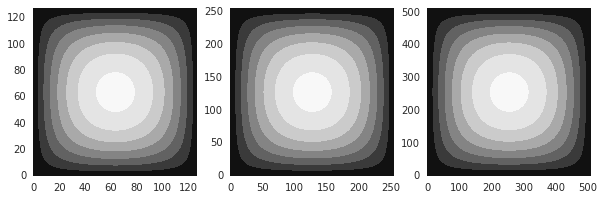

In [55]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
def get_system(n):
    ex = np.ones(n);
    a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
    e1 = sp.sparse.eye(n)
    lp2 = sp.sparse.kron(e1, a) + sp.sparse.kron(a, e1)
    lp2 = lp2 * (n + 1) ** 2 #Do not forget.
    return lp2, np.ones(n*n)
n_all = [128, 256, 512]
fig, ax = plt.subplots(1, len(n_all), figsize=(10, 3))
for i, n in enumerate(n_all):
    t = time.time()
    mat, rhs = get_system(n)
    sol = sp.sparse.linalg.spsolve(mat, rhs).reshape((n, n))
    t = time.time() - t
    print('Matrix size:{0: d}, time:{1: 3.1e}'.format(n*n, t))
    ax[i].contourf(sol)

## How to use this in solvers?

Any ideas, how to use this multigrid hierarchy in solvers?

Will a simple "interpolate" be enough?

## Fast direct solvers and H-matrices

I will describe our recent work.


## Summary
- Sparse matrices are important
- Fast direct solvers are often the method of choice for small-sized problems.
 

## Next lecture
- We will actually start the FastPDE course!

In [40]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()